In [1]:
import dotenv
import email.message
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pandas_datareader as oi
import pandas_datareader.data as web
import plotly.express as px
import plotly.graph_objects as go
import pymysql
import seaborn as sns
import smtplib
import sqlalchemy as db
from datetime import date
from email import encoders
from email.mime.application import MIMEApplication
from email.mime.base import MIMEBase
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from fredapi import Fred
from matplotlib import style
from pretty_html_table import build_table
from sklearn.preprocessing import MinMaxScaler
plt.style.use('seaborn-darkgrid')
dotenv.load_dotenv('senhas.env')
pd.options.display.max_columns=100
pd.options.display.float_format = '{:,.2f}'.format

## API access and Importing Data

In [2]:
fred_key = os.getenv('fred_key')
fred = Fred(api_key=fred_key)

In [3]:
def import_data_fred (code, name, start_date='2013-01-01', end_date=date.today()):
    result = fred.get_series(series_id= code, observation_start= start_date, observation_end=end_date)
    result = pd.DataFrame(result).reset_index().rename(columns={'index':'Date', 0: name})  
    return result

Purchase Only House Price Index for the United States (HPIPONM226S)

Units:  Index Jan 1991=100, Seasonally Adjusted

Frequency:  Monthly

The purchase-only index is based on more than 6 million repeat sales transactions on the same single-family properties.

In [4]:
national_house_price = import_data_fred('HPIPONM226S', 'House_Price')

S&P 500 (SP500)

Units:  Index, Not Seasonally Adjusted

Frequency:  Daily, Close

The S&P 500 is regarded as a gauge of the large cap U.S. equities market. The index includes 500 leading companies in leading industries of the U.S. economy, which are publicly held on either the NYSE or NASDAQ, and covers 75% of U.S. equities. Since this is a price index and not a total return index, the S&P 500 index here does not contain dividends.

In [5]:
sp500 = import_data_fred('SP500', 'SP500')

Unemployment Rate (UNRATE)

Units:  Percent, Seasonally Adjusted

Frequency:  Monthly

The unemployment rate represents the number of unemployed as a percentage of the labor force. Labor force data are restricted to people 16 years of age and older, who currently reside in 1 of the 50 states or the District of Columbia, who do not reside in institutions (e.g., penal and mental facilities, homes for the aged), and who are not on active duty in the Armed Forces.

In [6]:
unemployment = import_data_fred('UNRATE', 'Unemployment')

Median Consumer Price Index (MEDCPIM158SFRBCLE)

Units:  Percent Change at Annual Rate, Seasonally Adjusted

Frequency:  Monthly

Median Consumer Price Index (CPI) is a measure of core inflation calculated the Federal Reserve Bank of Cleveland and the Ohio State University. Median CPI was created as a different way to get a 'Core CPI' measure, or a better measure of underlying inflation trends. To calculate the Median CPI, the Cleveland Fed analyzes the median price change of the goods and services published by the BLS. The median price change is the price change that's right in the middle of the long list of all of the price changes. This series excludes 49.5% of the CPI components with the highest and lowest one-month price changes from each tail of the price-change distribution resulting in a Median CPI Inflation Estimate.

According to research from the Cleveland Fed, the Median CPI provides a better signal of the inflation trend than either the all-items CPI or the CPI excluding food and energy. According to newer research done at the Cleveland Fed, the Median CPI is even better at PCE inflation in the near and longer term than the core PCE.

In [7]:
inflation = import_data_fred('MEDCPIM158SFRBCLE','Inflation')

Federal Funds Effective Rate (DFF)

Units:  Percent, Not Seasonally Adjusted

Frequency:  Daily, 7-Day

The federal funds rate is the interest rate at which depository institutions trade federal funds (balances held at Federal Reserve Banks) with each other overnight. When a depository institution has surplus balances in its reserve account, it lends to other banks in need of larger balances. In simpler terms, a bank with excess cash, which is often referred to as liquidity, will lend to another bank that needs to quickly raise liquidity. (1) The rate that the borrowing institution pays to the lending institution is determined between the two banks; the weighted average rate for all of these types of negotiations is called the effective federal funds rate.(2) The effective federal funds rate is essentially determined by the market but is influenced by the Federal Reserve through open market operations to reach the federal funds rate target.(2)

In [8]:
federal_funds_rate = import_data_fred('DFF','FF_Rate')

In [9]:
def import_data_yahoo(ticker, start_day="2012-01-01", end_day=date.today() ):
    result = web.DataReader(ticker, data_source="yahoo", start=start_day, end=end_day)["Adj Close"]
    result = pd.DataFrame(result).reset_index().rename(columns={'Adj Close': ticker})
    return result

IVV is one of several ETFs that track the S&P 500 Index-delivers excellent large-cap exposure. 

In [10]:
ivv = import_data_yahoo('IVV')

SLYV is one fund in the small-cap value segment tracking the S&P SmallCap 600 Value Index. It tilts smaller than its benchmark and offers decent exposure to the small-cap value space. 

In [11]:
slyv = import_data_yahoo('SLYV')

VEA offers exposure to developed markets outside of North America, including Western Europe, Japan, and Australia.

In [12]:
vea = import_data_yahoo('VEA')

VWO offers exposure to emerging markets. Given the opportunity to establish broad-based exposure to the developing economies of the world.

In [13]:
vwo = import_data_yahoo('VWO')

## Data Cleaning and Preprocessing

In [14]:
def day_to_month(serie_name):
    convert = serie_name.groupby(serie_name['Date'].dt.strftime('%m %Y')).first().rename(columns={"Date":"Month"}).reset_index(drop=True)
    convert['Date'] = pd.to_datetime(convert['Month'].dt.year.astype(str)+'/'+convert['Month'].dt.month.astype(str)+'/01')
    convert = convert.drop(columns='Month').sort_values('Date').reset_index().drop(columns='index')
    return convert

In [15]:
sp500_monthly = day_to_month(sp500)

In [16]:
ff_rate_monthly = day_to_month(federal_funds_rate)

In [17]:
df_all_index = national_house_price.merge(sp500_monthly).merge(unemployment).merge(inflation).merge(ff_rate_monthly)
df_all_index['Date'] = df_all_index['Date'].dt.date
df_all_index

Date  House_Price    SP500  Unemployment  Inflation  FF_Rate
0    2013-01-01       189.47 1,462.42          8.00       2.74     0.09
1    2013-02-01       190.68 1,513.17          7.70       2.45     0.14
2    2013-03-01       192.60 1,518.20          7.50       1.22     0.14
3    2013-04-01       193.59 1,562.17          7.60       2.09     0.16
4    2013-05-01       195.12 1,582.70          7.50       1.96     0.14
..          ...          ...      ...           ...        ...      ...
112  2022-05-01       396.65 4,155.38          3.60       7.21     0.33
113  2022-06-01       397.19 4,101.23          3.60       9.13     0.83
114  2022-07-01       394.62 3,825.33          3.50       6.48     1.58
115  2022-08-01       392.05 4,118.63          3.70       9.22     2.33
116  2022-09-01       392.35 3,966.85          3.50       8.31     2.33

[117 rows x 6 columns]

In [18]:
df_all_etf = ivv.merge(slyv).merge(vea).merge(vwo)
df_all_etf['Date'] = df_all_etf['Date'].dt.date
df_all_etf

Date    IVV  SLYV   VEA   VWO
0     2012-01-03 104.54 24.48 22.91 29.45
1     2012-01-04 104.63 24.34 22.78 29.37
2     2012-01-05 104.97 24.51 22.45 29.23
3     2012-01-06 104.75 24.54 22.19 28.88
4     2012-01-09 104.88 24.48 22.24 29.11
...          ...    ...   ...   ...   ...
2750  2022-12-06 395.61 77.19 42.79 40.29
2751  2022-12-07 394.85 76.65 42.79 40.05
2752  2022-12-08 397.95 77.03 43.03 40.51
2753  2022-12-09 395.01 76.16 43.06 40.17
2754  2022-12-12 395.27 75.89 42.96 39.86

[2755 rows x 5 columns]

In [19]:
pd.options.display.float_format = '{:,.2f}'.format

nhp_last = national_house_price[-1:]
sp_last = sp500[-1:].rename(columns={'Day':'Date'})
unem_last = unemployment[-1:]
inf_last = inflation[-1:]
rate_last = federal_funds_rate[-1:].rename(columns={'Day':'Date'})
ivv_last = ivv[-1:]
slyv_last = slyv[-1:]
vea_last = vea[-1:]
vwo_last = vwo[-1:]

In [20]:
last_update = pd.concat([ivv_last,slyv_last,vea_last,vwo_last,nhp_last,sp_last,unem_last,inf_last,rate_last], axis=0).fillna(np.NAN).reset_index().drop(columns=['index'])
last_update['Date'] = last_update['Date'].dt.date
last_update = last_update.groupby('Date').max()
last_update

IVV  SLYV   VEA   VWO  House_Price    SP500  Unemployment  \
Date                                                                      
2022-09-01    NaN   NaN   NaN   NaN       392.35      NaN           NaN   
2022-10-01    NaN   NaN   NaN   NaN          NaN      NaN           NaN   
2022-11-01    NaN   NaN   NaN   NaN          NaN      NaN          3.70   
2022-12-08    NaN   NaN   NaN   NaN          NaN      NaN           NaN   
2022-12-09    NaN   NaN   NaN   NaN          NaN 3,934.38           NaN   
2022-12-12 395.27 75.89 42.96 39.86          NaN      NaN           NaN   

            Inflation  FF_Rate  
Date                            
2022-09-01        NaN      NaN  
2022-10-01       6.53      NaN  
2022-11-01        NaN      NaN  
2022-12-08        NaN     3.83  
2022-12-09        NaN      NaN  
2022-12-12        NaN      NaN

In [21]:
df_all_index.corr()['House_Price']

House_Price     1.00
SP500           0.97
Unemployment   -0.24
Inflation       0.74
FF_Rate         0.17
Name: House_Price, dtype: float64

In [22]:
df_all_etf.corr()['IVV']

IVV    1.00
SLYV   0.95
VEA    0.94
VWO    0.87
Name: IVV, dtype: float64

## Normalizing Data

In [23]:
pd.options.display.float_format = '{:,.5f}'.format
def price_normalize (df_name, column):
    convert = df_name.copy()
    convert[column] = MinMaxScaler().fit_transform(np.array(convert[column]).reshape(-1,1))
    return convert

In [24]:
housep_norm = price_normalize(national_house_price, 'House_Price')
sp_norm = price_normalize(sp500_monthly, 'SP500')
unemp_norm = price_normalize(unemployment, 'Unemployment')
infl_norm = price_normalize(inflation, 'Inflation')
rate_norm = price_normalize(ff_rate_monthly, 'FF_Rate')
df_index_norm = (housep_norm.merge(sp_norm).merge(unemp_norm).merge(infl_norm).merge(rate_norm))
df_index_norm

Date  House_Price   SP500  Unemployment  Inflation  FF_Rate
0   2013-01-01      0.00000 0.00000       0.40179    0.23538  0.01058
1   2013-02-01      0.00583 0.01522       0.37500    0.20114  0.02381
2   2013-03-01      0.01507 0.01673       0.35714    0.05530  0.02381
3   2013-04-01      0.01983 0.02992       0.36607    0.15835  0.02910
4   2013-05-01      0.02720 0.03608       0.35714    0.14272  0.02381
..         ...          ...     ...           ...        ...      ...
112 2022-05-01      0.99740 0.80769       0.00893    0.76273  0.07407
113 2022-06-01      1.00000 0.79145       0.00893    0.98909  0.20635
114 2022-07-01      0.98763 0.70870       0.00000    0.67676  0.40476
115 2022-08-01      0.97526 0.79667       0.01786    1.00000  0.60317
116 2022-09-01      0.97670 0.75115       0.00000    0.89203  0.60317

[117 rows x 6 columns]

In [25]:
ivv_norm = price_normalize(ivv,'IVV')
slyv_norm = price_normalize(slyv,'SLYV')
vea_norm = price_normalize(vea,'VEA')
vwo_norm = price_normalize(vwo,'VWO')
df_etf_norm = (ivv_norm.merge(slyv_norm).merge(vea_norm).merge(vwo_norm))
df_etf_norm

Date     IVV    SLYV     VEA     VWO
0    2012-01-03 0.00000 0.01305 0.06373 0.18817
1    2012-01-04 0.00024 0.01085 0.05943 0.18542
2    2012-01-05 0.00117 0.01349 0.04869 0.18067
3    2012-01-06 0.00055 0.01398 0.04010 0.16917
4    2012-01-09 0.00091 0.01305 0.04177 0.17692
...         ...     ...     ...     ...     ...
2750 2022-12-06 0.78714 0.82533 0.71508 0.54998
2751 2022-12-07 0.78509 0.81701 0.71508 0.54197
2752 2022-12-08 0.79347 0.82287 0.72294 0.55732
2753 2022-12-09 0.78552 0.80946 0.72393 0.54597
2754 2022-12-12 0.78621 0.80531 0.72065 0.53555

[2755 rows x 5 columns]

In [26]:
pd.options.display.float_format = '{:,.2f}'.format

## Graphics 

### Candlestick charts - ETF

- The candlestick chart shows the market's open, high, low, and close price for the day. Traders use the candlesticks to make trading decisions based on regularly occurring patterns that help forecast the short-term direction of the price.

In [27]:
def import_ticker_price(ticker, back_days=180, end_day=date.today()):
    back = date.fromordinal(date.today().toordinal()-back_days)
    result = web.DataReader(ticker, data_source="yahoo", start=back, end=end_day)
    result = pd.DataFrame(result).reset_index()
    result.set_index('Date')
    return result

In [28]:
def candle_chart(df, fig_title):
    fig = go.Figure(data=[go.Candlestick(x=df['Date'],open=df['Open'], high=df['High'],low=df['Low'], close=df['Close'])])
    fig.update_layout(xaxis_rangeslider_visible=False,title=fig_title)
    return fig.show()

In [29]:
ivv_180d_table = import_ticker_price('IVV')
slyv_180d_table = import_ticker_price('SLYV')
vea_180d_table = import_ticker_price('VEA')
vwo_180d_table = import_ticker_price('VWO')

In [30]:
ivv_180d_candle = candle_chart(ivv_180d_table, "IVV - 180 days")

In [31]:
slyv_180d_candle = candle_chart(slyv_180d_table, "SLYV - 180 days")

In [32]:
vea_180d_candle = candle_chart(vea_180d_table, "VEA - 180 days")

In [33]:
vwo_180d_candle = candle_chart(vwo_180d_table, "VWO - 180 days")

### Bollinger Band - ETF

- A Bollinger Band is a technical analysis tool developed by John Bollinger for generating oversold or overbought signals. It is defined by a set of trendlines plotted two standard deviations (positively and negatively) away from a simple moving average (SMA) of a security's price, but which can be adjusted to user preferences.

In [34]:
def bollinger_band_table(ticker, back_days=180, end_day=date.today()):
    back = date.fromordinal(date.today().toordinal()-back_days)
    df = web.DataReader(ticker, data_source="yahoo", start=back, end=end_day)
    df = pd.DataFrame(df).reset_index()
    df['SMA'] = df['Close'].rolling(window=20).mean()
    df['STD'] = df['Close'].rolling(window=20).std()
    df['Upper Band'] = df['SMA'] + df['STD']*2
    df['Lower Band'] = df['SMA'] - df['STD']*2
    df = df[['Date','Close','SMA','Upper Band','Lower Band']]
    df.rename(columns={'Close':'Close Price','SMA':'20-day SMA'}, inplace=True)
    return df

In [35]:
def bollinger_band_chart(df, title):
    full_title = f'Bollinger Band - {title}'
    fig = (df.set_index('Date')).plot(figsize=(18,5))
    fig.set_title(full_title, fontsize=16)
    fig.set_xlabel("Year", fontsize=14)
    fig.legend(fontsize=10);
    return fig

In [36]:
ivv_bollinger_table = bollinger_band_table('IVV')
slyv_bollinger_table = bollinger_band_table('SLYV')
vea_bollinger_table = bollinger_band_table('VEA')
vwo_bollinger_table = bollinger_band_table('VWO')

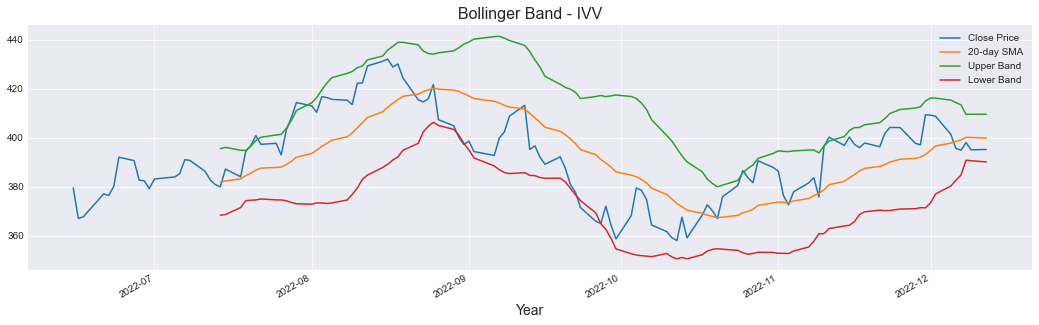

In [37]:
ivv_bollinger = bollinger_band_chart(ivv_bollinger_table, 'IVV')

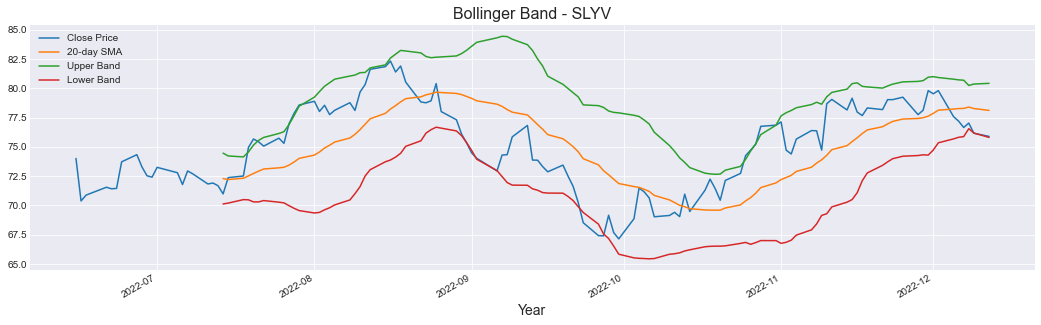

In [38]:
slyv_bollinger = bollinger_band_chart(slyv_bollinger_table,'SLYV')

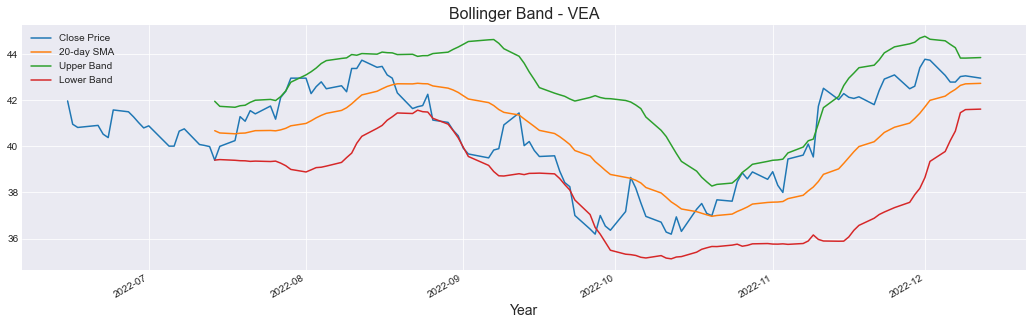

In [39]:
vea_bollinger = bollinger_band_chart(vea_bollinger_table,'VEA')

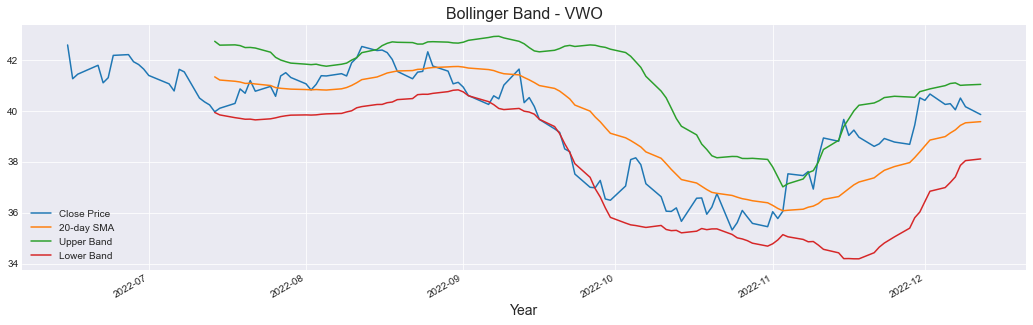

In [40]:
vwo_bollinger = bollinger_band_chart(vwo_bollinger_table,'VWO')

### house price index comparison with other indexes

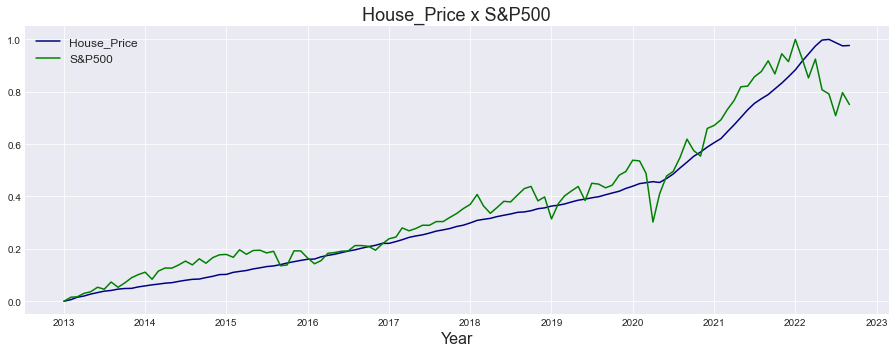

In [41]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_axes([0,0,1,1])
ax.plot(df_index_norm.set_index('Date')['House_Price'], color='navy', label='House_Price')
ax.plot(df_index_norm.set_index('Date')['SP500'], color='green', label='S&P500')
ax.set_title('House_Price x S&P500', fontsize=18)
ax.set_xlabel("Year", fontsize=16)
ax.legend(fontsize=12);

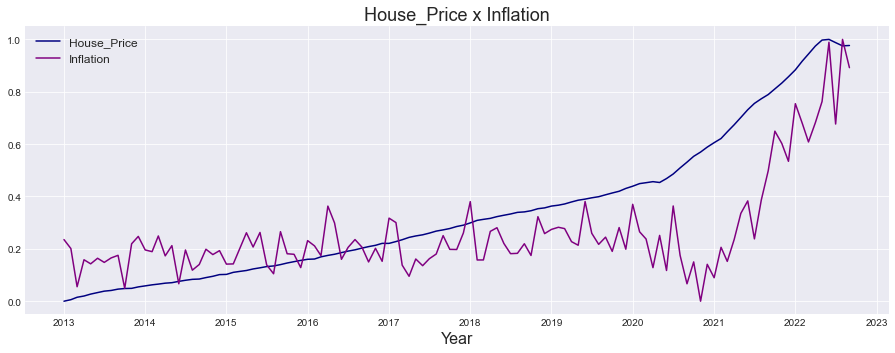

In [42]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_axes([0,0,1,1])
ax.plot(df_index_norm.set_index('Date')['House_Price'], color='navy', label='House_Price')
ax.plot(df_index_norm.set_index('Date')['Inflation'], color='purple', label='Inflation')
ax.set_title('House_Price x Inflation', fontsize=18)
ax.set_xlabel("Year", fontsize=16)
ax.legend(fontsize=12);

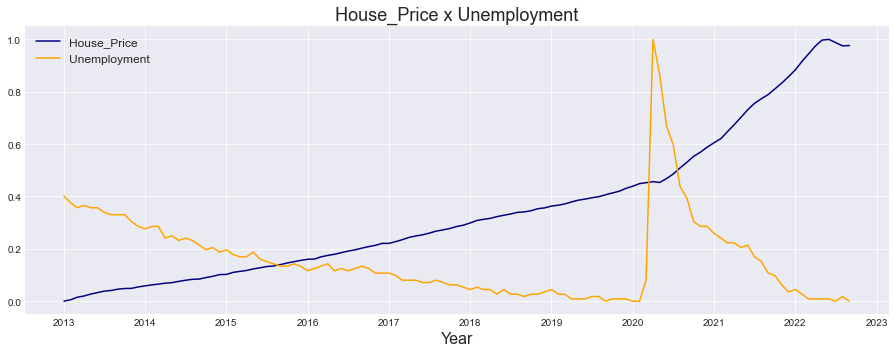

In [43]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_axes([0,0,1,1])
ax.plot(df_index_norm.set_index('Date')['House_Price'], color='navy', label='House_Price')
ax.plot(df_index_norm.set_index('Date')['Unemployment'], color='orange', label='Unemployment')
ax.set_title('House_Price x Unemployment', fontsize=18)
ax.set_xlabel("Year", fontsize=16)
ax.legend(fontsize=12);

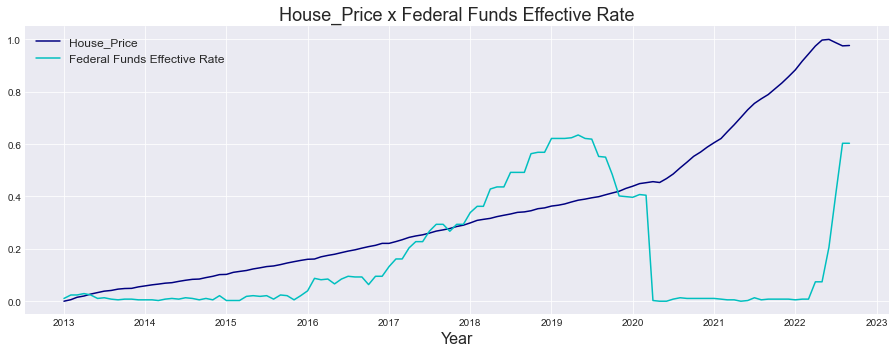

In [44]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_axes([0,0,1,1])
ax.plot(df_index_norm.set_index('Date')['House_Price'], color='navy', label='House_Price')
ax.plot(df_index_norm.set_index('Date')['FF_Rate'], color='c', label='Federal Funds Effective Rate')
ax.set_title('House_Price x Federal Funds Effective Rate', fontsize=18)
ax.set_xlabel("Year", fontsize=16)
sns.color_palette()
ax.legend(fontsize=12);

## Exporting Data

In [ ]:
sql_password = os.getenv('sql_password')
user = "lenagrumbach"
password = sql_password
url_banco = "localhost"
nome_db = "finance_api"
conn_str = f"mysql+pymysql://{user}:{password}@{url_banco}/{nome_db}"
engine = db.create_engine(conn_str)

In [ ]:
df_all_index.to_sql(name='df_all_index', con=engine,if_exists='replace', index=False)

In [ ]:
df_all_etf.to_sql(name='df_all_etf', con=engine,if_exists='replace', index=False)

In [45]:
df_all_index.to_excel('df_all_index.xlsx', index=False)

In [46]:
df_all_etf.to_excel('df_all_etf.xlsx', index=False)

In [47]:
last_update.to_excel('last_update.xlsx', index=False)

In [48]:
df_index_norm.to_excel('df_index_norm.xlsx', index=False)

In [49]:
df_etf_norm.to_excel('df_etf_norm.xlsx', index=False)

## Sending emails

In [53]:
# importing data for e-mail send list
stakeholder_list =  pd.read_excel('stakeholder_list.xlsx')
active_emails = stakeholder_list.loc[stakeholder_list['Active']=='ok']

In [54]:
table_email = build_table(last_update.reset_index(), color='blue_light', font_size='12px')

In [55]:
from datetime import datetime
logging.basicConfig(level = logging.INFO, filename= 'email_report.log', encoding='utf-8')

In [56]:
def send_email(send_to, send_from='lena.dataanalyst@gmail.com', subject='Daily update'):
    dotenv.load_dotenv('senhas.env')
    gmail_password = os.getenv('gmail_password')

    body_email = f"""
    <p>Hello,

    <p> Please see below for updated information.

    {table_email}


    <p>Kind regards,
    <p>Lena Grumbach
    </p>
    """
    msg= MIMEMultipart()
    msg['Subject'] = subject
    msg['From'] = send_from
    msg['To'] = send_to
    msg.attach(MIMEText(body_email, 'html'))
    
    file_path = "C:/Users/lenag/OneDrive/Desktop/IRONHACK/Projetos/BootcampFinalProject/pipeline_project/last_update.xlsx"
    attachment = open(file_path, 'rb')
    att = MIMEBase('application','octet-stream')
    att.set_payload(attachment.read())
    encoders.encode_base64(att)
    att.add_header('Content-Disposition', f"attachment; filename=last_update.xlsx")
    attachment.close()
    msg.attach(att)

    host = 'smtp.gmail.com'
    port = '587'
    login = send_from
    password = gmail_password
    server = smtplib.SMTP(host,port)
    server.ehlo()
    server.starttls()
    server.login(login,password)
    server.sendmail(msg['From'], msg['To'], msg.as_string().encode('utf-8'))
    server.quit()

In [57]:
# Send with log file
send_list = list(active_emails['Contact']) 
confirm_list = []
for i in send_list:
    send_email(i)
    confirm_list.append(f"Sent to {i} at {datetime.today()}")
logging.info(confirm_list)
print('done')

done
